# Sentiment Analysis - Comparing a Rule-Based vs. ML-based Model

Purpose: Sentiment Analysis is a Natural Language Processing (NLP) technique used to determine whether a piece of text is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

For this notebook, I am analyzing the sentiments of ~500 survey questions from surveys that measure masculinity. In effect, I am looking to see whether the beliefs and behaviors that are being measured contain positive/neutral/negative sentiments.

I am comparing a rule-based (lexicon-based) method (VADER) against a machine-learning based model (RoBERTa).

Inspiration: 
- https://www.youtube.com/watch?v=QpzMWQvxXWk&t=201s
- https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

## Imports and Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacobrubin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jacobrubin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jacobrubin/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/jacobrubin/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacobrubin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
df = pd.read_csv('./Questions2.csv')
print(df.shape)


(395, 9)


In [6]:
df.head()

,Id,Scale,Year of Publication,Nickname,Factor Structure,Test Structure,Other Info,Data Source,Question Text
0,1,Conformity to Masculine Norms Inventory,2003,CMNI,Emotional Control,4-point Likert Scale,NaN,NaN,It is best to keep your emotions hidden
1,2,Conformity to Masculine Norms Inventory,2003,CMNI,Winning,NaN,NaN,NaN,In general‚ I will do anything to win
2,3,Conformity to Masculine Norms Inventory,2003,CMNI,Playboy,NaN,NaN,NaN,If I could‚ I would frequently change sexual p...
3,4,Conformity to Masculine Norms Inventory,2003,CMNI,Violence,NaN,NaN,NaN,If there is going to be violence‚ I find a way...
4,5,Conformity to Masculine Norms Inventory,2003,CMNI,Disdain for Homosexuals,NaN,NaN,NaN,It is important to me that people think I am h...


## Let's First Play Around with the NLTK library

In [7]:
example = df["Question Text"][50]

tokens = nltk.word_tokenize(example)
tokens[:10]

['It', 'would', 'be', 'awful', 'if', 'people', 'thought', 'I', 'was', 'gay']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('It', 'PRP'),
 ('would', 'MD'),
 ('be', 'VB'),
 ('awful', 'JJ'),
 ('if', 'IN'),
 ('people', 'NNS'),
 ('thought', 'VBD'),
 ('I', 'PRP'),
 ('was', 'VBD'),
 ('gay', 'NN')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  It/PRP
  would/MD
  be/VB
  awful/JJ
  if/IN
  people/NNS
  thought/VBD
  I/PRP
  was/VBD
  gay/NN)


# VADER 

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores(example)

{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'compound': -0.4588}

In [12]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Question Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/395 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [14]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,Scale,Year of Publication,Nickname,Factor Structure,Test Structure,Other Info,Data Source,Question Text
0,1,0.000,0.625,0.375,0.6369,Conformity to Masculine Norms Inventory,2003,CMNI,Emotional Control,4-point Likert Scale,NaN,NaN,It is best to keep your emotions hidden
1,2,0.000,0.612,0.388,0.5859,Conformity to Masculine Norms Inventory,2003,CMNI,Winning,NaN,NaN,NaN,In general‚ I will do anything to win
2,3,0.000,1.000,0.000,0.0000,Conformity to Masculine Norms Inventory,2003,CMNI,Playboy,NaN,NaN,NaN,If I could‚ I would frequently change sexual p...
3,4,0.167,0.833,0.000,-0.2960,Conformity to Masculine Norms Inventory,2003,CMNI,Violence,NaN,NaN,NaN,If there is going to be violence‚ I find a way...
4,5,0.000,0.833,0.167,0.2023,Conformity to Masculine Norms Inventory,2003,CMNI,Disdain for Homosexuals,NaN,NaN,NaN,It is important to me that people think I am h...


## Plot VADER Results

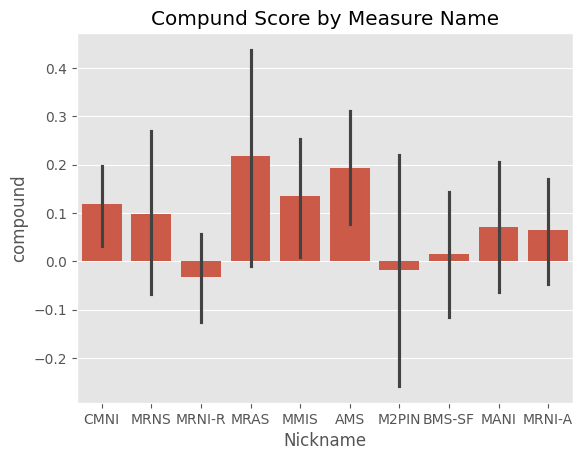

In [17]:
ax = sns.barplot(data=vaders, x='Nickname', y='compound')
ax.set_title('Compund Score by Measure Name')
plt.show()

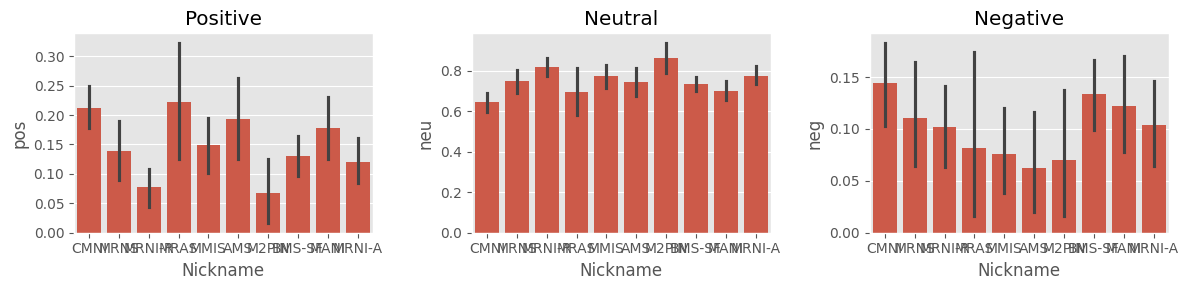

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Nickname', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Nickname', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Nickname', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# RoBERTa

In [91]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [92]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [104]:
# VADER results on example
print(example)
sia.polarity_scores(example)

It would be awful if people thought I was gay


{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'compound': -0.4588}

In [105]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.95091987, 'roberta_neu': 0.045858383, 'roberta_pos': 0.0032217295}


In [95]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [96]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Question Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/395 [00:00<?, ?it/s]

In [97]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Plot RoBERTa Results

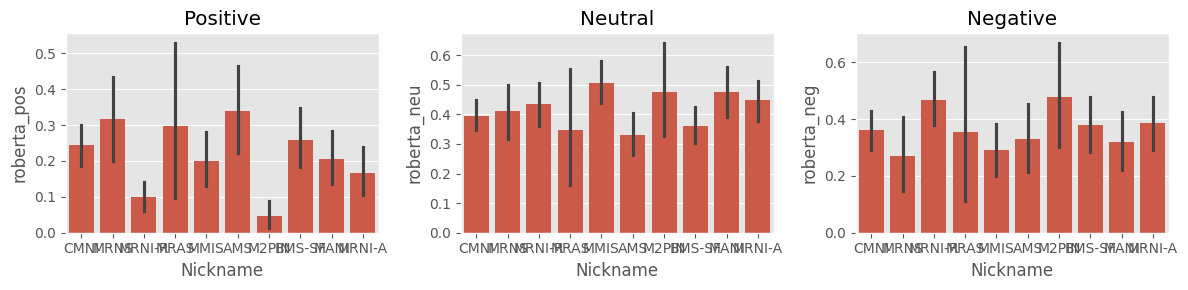

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='Nickname', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='Nickname', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='Nickname', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Compare Results

In [99]:
# Comparison of Overall Scores

dict_results = {"Roberta Pos: ": results_df.loc[:, 'roberta_pos'].mean(),
                "Vader Pos: ": results_df.loc[:, 'vader_pos'].mean(),
                "Roberta Neu: ": results_df.loc[:, 'roberta_neu'].mean(),
                "Vader Neu: ": results_df.loc[:, 'vader_neu'].mean(),
                "Roberta Neg: ": results_df.loc[:, 'roberta_neg'].mean(),
                "Vader Neg: ": results_df.loc[:, 'vader_neg'].mean()
               }
dict_results

{'Roberta Pos: ': 0.22088747064942565,
 'Vader Pos: ': 0.15447848101265824,
 'Roberta Neu: ': 0.41556168759736833,
 'Vader Neu: ': 0.7327924050632911,
 'Roberta Neg: ': 0.3635508398487103,
 'Vader Neg: ': 0.11272911392405063}

In [100]:
results_df.columns

results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Scale,Year of Publication,Nickname,Factor Structure,Test Structure,Other Info,Data Source,Question Text
0,1,0.000,0.625,0.375,0.6369,0.159830,0.732099,0.108071,Conformity to Masculine Norms Inventory,2003,CMNI,Emotional Control,4-point Likert Scale,NaN,NaN,It is best to keep your emotions hidden
1,2,0.000,0.612,0.388,0.5859,0.011003,0.215077,0.773920,Conformity to Masculine Norms Inventory,2003,CMNI,Winning,NaN,NaN,NaN,In general‚ I will do anything to win
2,3,0.000,1.000,0.000,0.0000,0.128896,0.749415,0.121689,Conformity to Masculine Norms Inventory,2003,CMNI,Playboy,NaN,NaN,NaN,If I could‚ I would frequently change sexual p...
3,4,0.167,0.833,0.000,-0.2960,0.341258,0.616999,0.041743,Conformity to Masculine Norms Inventory,2003,CMNI,Violence,NaN,NaN,NaN,If there is going to be violence‚ I find a way...
4,5,0.000,0.833,0.167,0.2023,0.059397,0.664210,0.276393,Conformity to Masculine Norms Inventory,2003,CMNI,Disdain for Homosexuals,NaN,NaN,NaN,It is important to me that people think I am h...


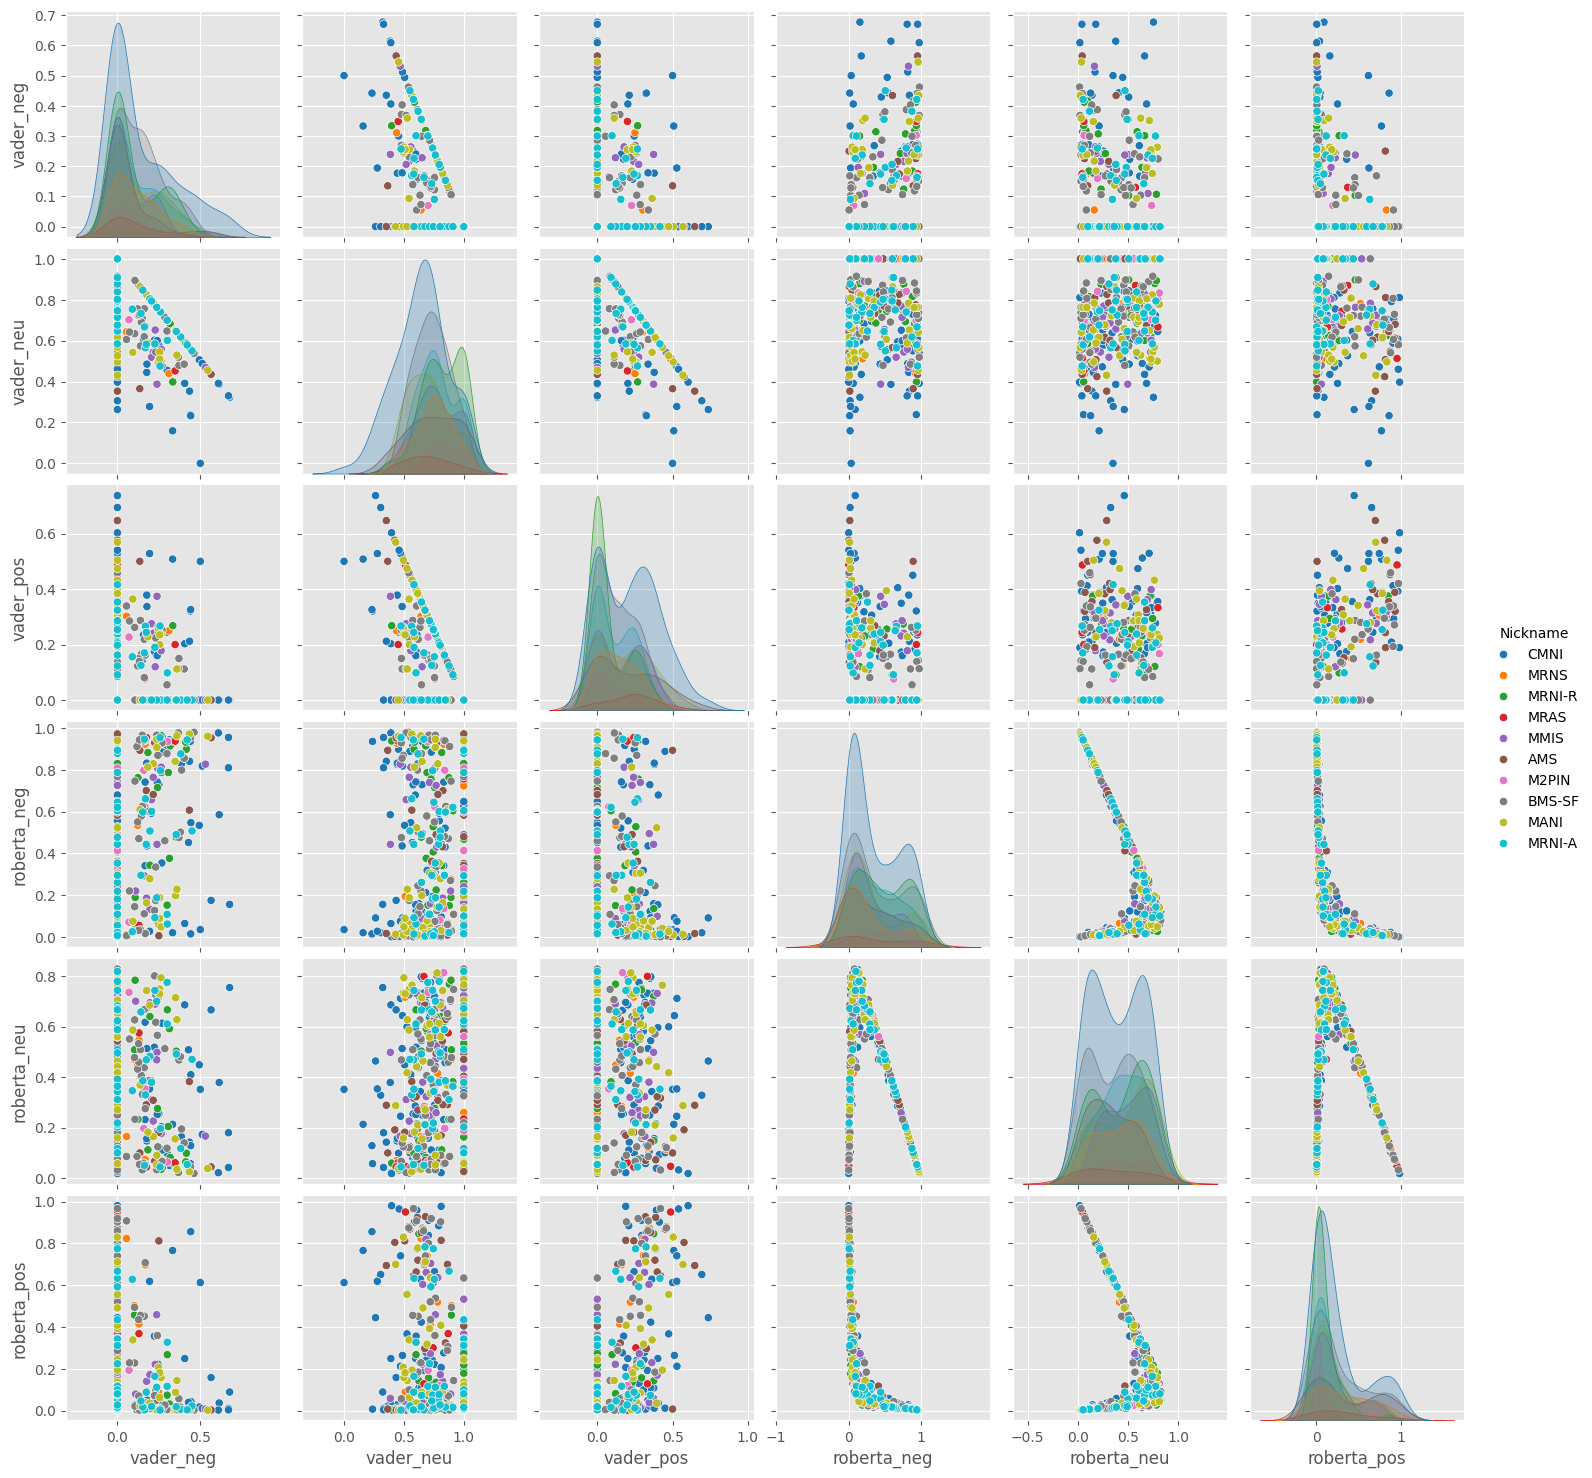

In [101]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Nickname',
            palette='tab10')
plt.show()